# Deconvolving the Mixing Matrix

The goal of this notebook is showcase the natural unmixing method to account for masking in the fields implemented in Heracles.


## Dependencies

In [1]:
import heracles
import numpy as np
import healpy as hp
import matplotlib as mpl
import matplotlib.pyplot as plt
from heracles.twopoint import mixing_matrices
from heracles.result import Result

## Load in Cls

We will reuse the Cls computed the general example notebook.

In [2]:
cls = heracles.read("./example-spectra.fits")
mask_cls = heracles.read("./example-mask-spectra.fits")

# In the future it will not be necessary to trim the mask cls
# to the same lmax
lmax = 1500
for key in mask_cls.keys():
    mask_cls[key] = heracles.Result(mask_cls[key].array[:lmax + 1], axis=mask_cls[key].axis)

## Theory

For the time being we will recompute the full-sky theory although it is the same as in the general example notebook.

In [3]:
import camb
from camb.sources import SplinedSourceWindow

In [4]:
#nbins
nbins = 7

# cosmology for the simulation
h = 0.7
Oc = 0.25
Ob = 0.05

# set up CAMB parameters for matter angular power spectrum
pars = camb.set_params(
    H0=100 * h, omch2=Oc * h**2, ombh2=Ob * h**2, NonLinear=camb.model.NonLinear_both
)
pars.Want_CMB = False
pars.min_l = 1
pars.set_for_lmax(2 * lmax, lens_potential_accuracy=1);

In [5]:
with np.load("nz.npz") as npz:
    z, nz = npz["z"], npz["nz"]

In [6]:
sources = []
for i, nz_i in enumerate(nz):
    sources += [
        SplinedSourceWindow(source_type="counts", z=z, W=nz_i),
        SplinedSourceWindow(source_type="lensing", z=z, W=nz_i),
    ]
pars.SourceWindows = sources

In [7]:
results = camb.get_results(pars)
camb_cls = results.get_source_cls_dict(lmax=2 * lmax, raw_cl=True)

In [8]:
ell = np.arange(lmax + 1)
ell2 = np.arange(2 * lmax + 1)
fl = -np.sqrt((ell2 + 2) * (ell2 + 1) * ell2 * (ell2 - 1))
fl /= np.clip(ell2 * (ell2 + 1), 1, None)

In [9]:
theory = {}
for i in range(1, nbins):
    for j in range(i, nbins):
        # all mixing matrix combinations
        theory["POS", "POS", i, j] = camb_cls[f"W{2 * i - 1}xW{2 * j - 1}"]
        theory["POS", "SHE", i, j] = np.stack(
            [
                fl * camb_cls[f"W{2 * i - 1}xW{2 * j}"],
                np.zeros_like(ell2),
            ]
        )
        theory["POS", "SHE", j, i] = np.stack(
            [
                fl * camb_cls[f"W{2 * i}xW{2 * j - 1}"],
                np.zeros_like(ell2),
            ]
        )
        theory["SHE", "SHE", i, j] = np.stack(
            [
                [fl**2 * camb_cls[f"W{2 * i}xW{2 * j}"], np.zeros_like(ell2)],
                [np.zeros_like(ell2), np.zeros_like(ell2)],
            ]
        )

for key in theory.keys():
    c = cls[key]
    theory[key] = Result(theory[key], axis=c.axis, ell=ell2)

## Binning

In [10]:
nlbins = 10
ledges = np.logspace(np.log10(10), np.log10(lmax), nlbins + 1)

## Natural Unmixing

In the nautral unmixing method we account for the effect of the mask in real space. 
Let's start laying down some definitions. Given a complex field:
$$ \gamma(n) = (Q \pm i U)(n) = \sum_{l m} (E_{l m} \mp i B_{l m}) _{\mp 2} Y_{l m}(n)  $$
we can define the correlators:
$$ \xi_{+} = \langle \gamma^* \gamma\rangle  \hspace{6pt}\rm{and}\hspace{6pt} \xi_{-} = \langle \gamma \gamma \rangle $$
Then the associated parital sky correlatiors are given by:
$$ \xi_{\pm}(\theta) = \frac{\tilde{\xi}_{\pm}(\theta)}{\xi^{ww'}(\theta)} $$
which we can also express in terms of linear combinations of the measured $E$ and $B$ angular power spectra:
$$  \tilde{\xi}_{\pm}(\theta) = \sum_l \frac{2l+1}{4\pi}(\tilde{C}^{EE}_l \pm  \tilde{C}^{BB}_l) d^l_{2 \pm 2}(\theta) $$

The PolSpice method undoes the $E-B$ coupling by defining a correlator akin to $\xi_{+}(\theta)$ but with the Wigner matrix of a spin -2 field:
$$
\xi_{\rm dec}(\theta) = \frac{\tilde{\xi}_{\rm dec}(\theta)}{\xi^{ww'}(\theta)} = \nonumber \\ 
= \frac{1}{\xi^{ww'}(\theta)} \sum_l \frac{2l+1}{4\pi}(\tilde{C}^{EE}_l +  \tilde{C}^{BB}_l) d^l_{2 - 2}(\theta)
$$

Then one can construct a estimator for the full sky angular correlation functions by combining the correlation function and inverting the SWSH transform:
$$
C^{EE}_l = 2\pi \int \frac{1}{2}[\xi_{\rm dec}(\theta) + \xi_{-}(\theta)] d^{l}_{2-2}(\theta) {\rm d}\!\cos{\theta} $$
$$
C^{BB}_l = 2\pi \int \frac{1}{2}[\xi_{\rm dec}(\theta) - \xi_{-}(\theta)] d^{l}_{2-2}(\theta) {\rm d}\!\cos{\theta} $$

In [11]:
nu_d = heracles.natural_unmixing(cls, mask_cls, patch_hole=True)
nu_dq = heracles.binned(nu_d, ledges)
theory_q = heracles.binned(theory, ledges)

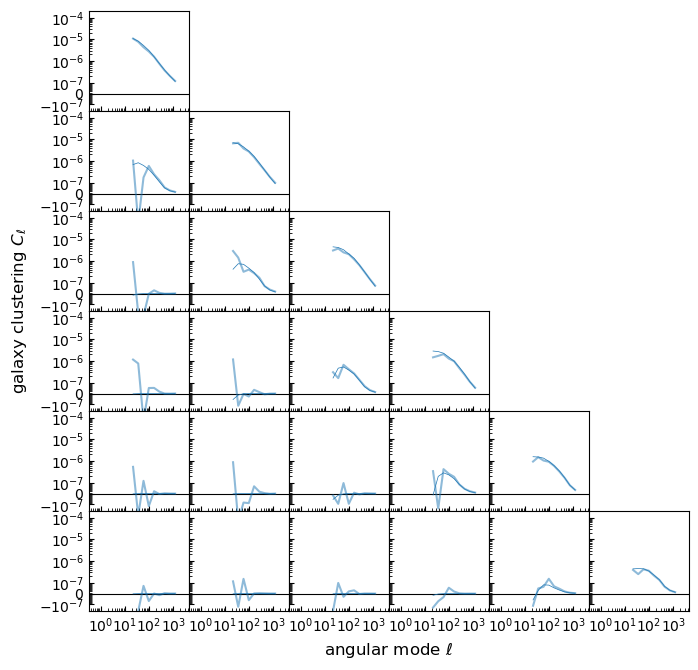

In [20]:
plot_clustering(nu_dq, theory_q);

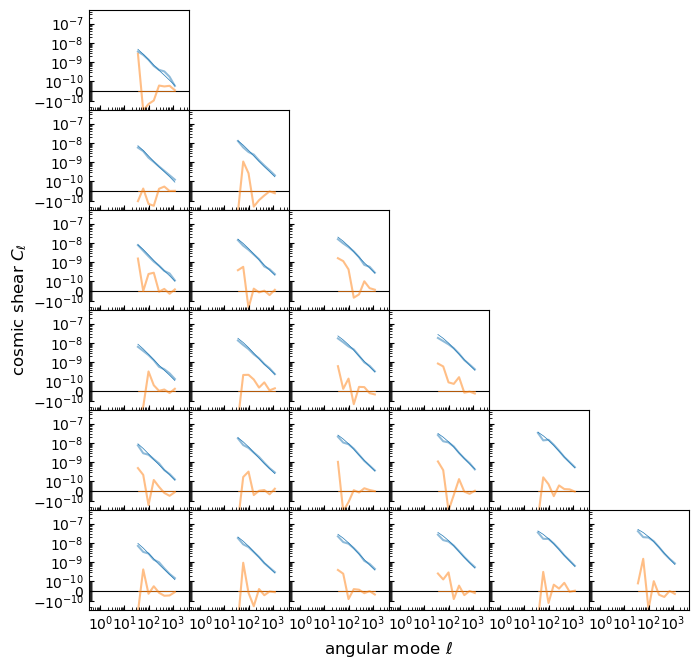

In [21]:
plot_shear(nu_dq, theory_q);

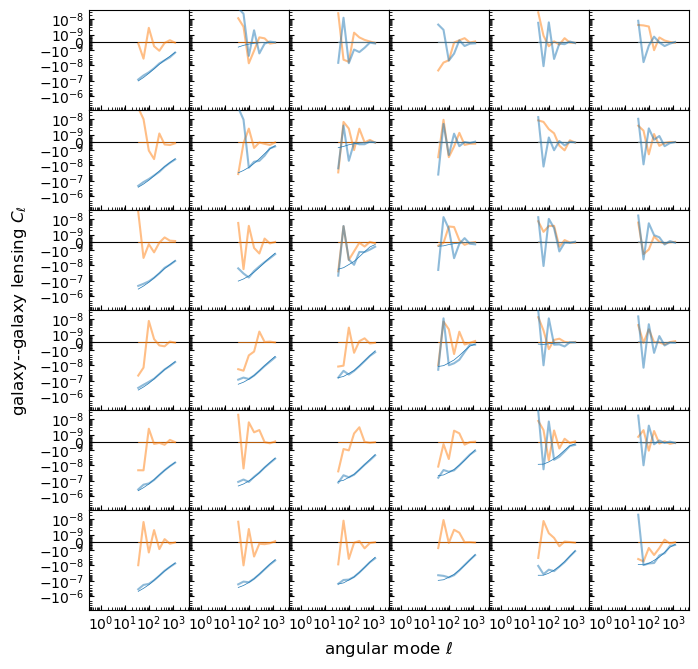

In [22]:
plot_clusteringxshear(nu_dq, theory_q);